In [43]:
import psycopg2
import os

In [44]:
import matplotlib.pyplot as plt
cm = 1/2.54

# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y

def group_bottom_percent(labels, sizes, threshold):
    total = sum(sizes)
    labels_filtered = []
    sizes_filtered = []
    count = 0
    other_count = 0
    for label, size in zip(labels, sizes):
        if size / total < threshold:
            count += 1
            other_count += size
        else:
            labels_filtered.append(label)
            sizes_filtered.append(size)
    labels_filtered.append(f'other ({count})')
    sizes_filtered.append(other_count)
    return labels_filtered, sizes_filtered

In [45]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cur = conn.cursor()

insert_cursor = conn.cursor()

In [46]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/remote_interpreter/dataset/jupyter


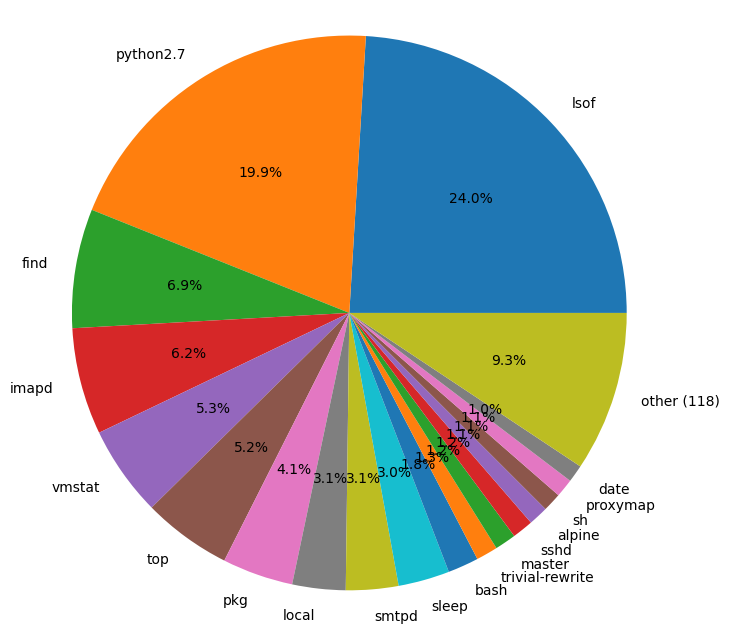

In [47]:
# visualize event distribution
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
group by e.properties_map_exec;
'''

cur.execute(query)
results_count_distinct_execs = cur.fetchall()

# plot exec distribution

# sort by count
results_count_distinct_execs.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs]
sizes = [row[1] for row in results_count_distinct_execs]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches((20*cm, 20*cm))

plt.savefig('figures/executable_events_distribution.svg')
plt.show()

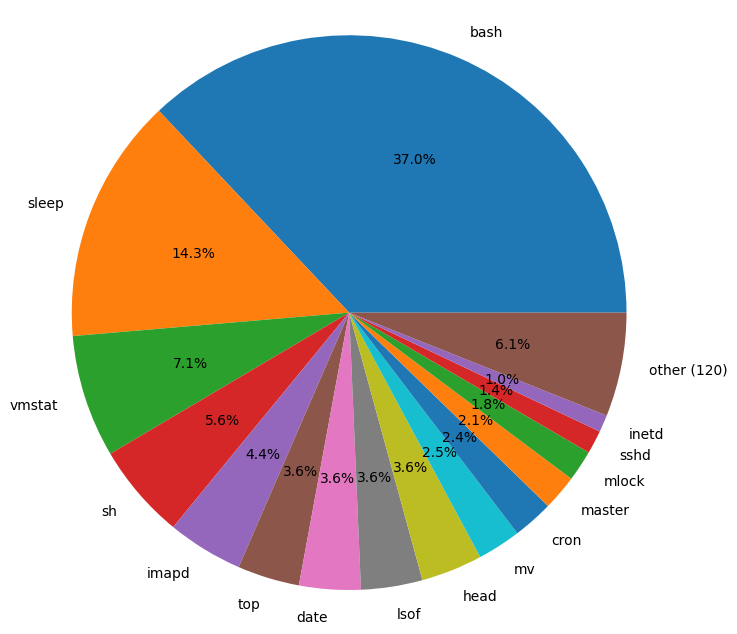

In [48]:
# visualize class distribution
query = '''
select executable, count(executable) as count
from sequence
group by executable
order by count desc;
'''

cur.execute(query)
result = cur.fetchall()

labels = [row[0] for row in result]
sizes = [row[1] for row in result]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((20*cm, 20*cm))

plt.savefig('figures/class_distribution.svg')
plt.show()

In [49]:
# visualize class distribution with sliding window 
window_size = 1000
query = f'''
select executable, length
from sequence
'''

occurrence = {}

cur.execute(query)
for row in cur:
    executable, length = row
    
    if executable not in occurrence:
        occurrence[executable] = 0
        
    if length <= window_size:
        occurrence[executable] += 1
    else:
        occurrence[executable] += length // window_size + 1 if length % window_size != 0 else 0

# convert dict to list of tuples
occurrence = [(k, v) for k, v in occurrence.items()]

bottom 10 labels:
touch: 1
chown: 1
chmod: 1
nice: 1
lsvfs: 1
main: 1
ssh: 1
locale: 1
whoami: 1
vUgefal: 1


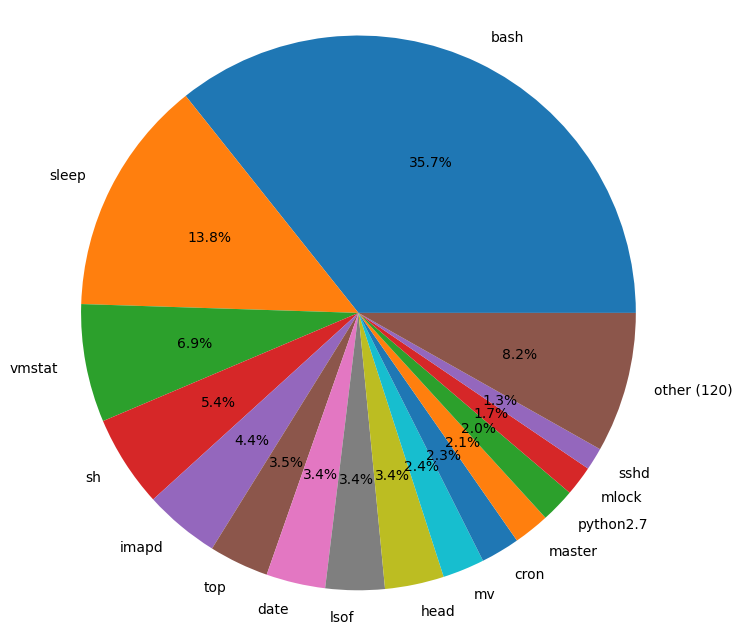

In [52]:
# sort by count
occurrence.sort(key=lambda x: x[1], reverse=True)


labels = [row[0] for row in occurrence]
sizes = [row[1] for row in occurrence]

# print bottom 10 labels with their sizes
print('bottom 10 labels:')
for label, size in zip(labels[-10:], sizes[-10:]):
    print(f'{label}: {size}')

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((20*cm, 20*cm))

plt.savefig(f'figures/class_distribution_windowed_{window_size}.svg')
plt.show()

In [ ]:
# destroy cursor and connection
cur.close()
conn.close()